In [ ]:
import os
import cv2
import numpy as np
import torch
from segment_anything import sam_model_registry, SamPredictor
from ultralytics import YOLO
import supervision as sv


def convert_bbox_x1y1x2y2_to_xywh(x1, y1, x2, y2):
    """
    Function to convert bounding box coordinates from top-left and bottom-right
    points to top-left point with width and height.
    
    Args:
        x1, y1, x2, y2 (int): Bounding box coordinates.
        
    Returns:
        x, y, w, h (int): Converted bounding box coordinates.
    """
    w = x2 - x1
    h = y2 - y1
    x = x1
    y = y1
    return x, y, w, h


# Define the model type and checkpoint path
MODEL_TYPE = "vit_l"  # Ensure this matches your downloaded model type
CHECKPOINT_PATH = os.path.join(os.getcwd(), "models", "sam_vit_l.pth")
YOLO_WEIGHTS = "path/to/yolo/weights"

def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")




def get_image_paths(image_dir):
    """
    Function to get all image paths in a directory.
    
    Args:
        image_dir (str): Path to the directory containing the images.
        
    Returns:
        image_paths (list): List of paths to the images.
    """
    image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".jpg")]
    return image_paths


def segment_image(yolo, mask_predictor, image_path):
    """
    Function to perform segmentation on an image.
    
    Args:
        yolo (YOLO): YOLO object for prediction.
        mask_predictor (SamPredictor): SAM model object for prediction.
        image_path (str): Path to the image to be segmented.
        
    Returns:
        None
    """
    yolo_output = yolo.predict(image_path, conf=0.5)

    r = []
    for result in yolo_output:
        for bbox in result.boxes.data,:
            box = bbox.int().cpu().numpy()
            for b in box:
                x, y, w, h = convert_bbox_x1y1x2y2_to_xywh(b[0], b[1], b[2], b[3])
                r.append([b[0], b[1], b[2], b[3], b[5]])

    # Create the image variable and box_annotator
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask_combined = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
    output = np.zeros_like(image)

    for i, box in enumerate(r):
        box = box[:-1]
        box = np.array(box)

        mask_predictor.set_image(image)
    
        masks, scores, logits = mask_predictor.predict(box=box, multimask_output=True)

        detections = sv.Detections(xyxy=sv.mask_to_xyxy(masks=masks), mask=masks)
        detections = detections[detections.area == np.max(detections.area)]

        # Combine the masks with a logical OR operation within the loop
        for m in masks:
            mask_combined = np.logical_or(mask_combined, m)
        
    # Use the combined mask to select the pixels of the original image
    output[mask_combined] = image[mask_combined]

    # Save the image with the original colors
    save_path = f"images/segmented_images/outfit_{os.path.basename(image_path).replace('.jpg', '.png')}"
    cv2.imwrite(save_path, cv2.cvtColor(output, cv2.COLOR_RGB2BGR))  # Convert back to BGR for saving


def main():
    """
    Main function to perform segmentation on all images in a directory.
    """
    MODEL_TYPE = "vit_l"
    CHECKPOINT_PATH = os.path.join(os.getcwd(), "models", "sam_weights.pth")
    YOLO_WEIGHTS = "models/yolo_weights.pt"
    IMAGE_DIR = "images/original_images"
    
    # Make sure the segmented images directory exists
    if not os.path.exists("images/segmented_images"):
        os.makedirs("images/segmented_images")

    # Create the YOLO and SAM models
    yolo = YOLO(YOLO_WEIGHTS)
    sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=get_device())
    mask_predictor = SamPredictor(sam)
    
    # Segment all images in the directory
    image_paths = get_image_paths(IMAGE_DIR)
    for image_path in image_paths:
        # Define the path of the segmented image
        segmented_image_path = f"images/segmented_images/outfit_{os.path.basename(image_path).replace('.jpg', '.png')}"
        
        # Check if the segmented image already exists
        if os.path.exists(segmented_image_path):
            print(f"Segmented image {segmented_image_path} already exists, skipping.")
            continue

        # If it doesn't exist, perform the segmentation
        segment_image(yolo, mask_predictor, image_path)


if __name__ == "__main__":
    main()


Segmented image images/segmented_images/outfit_1.png already exists, skipping.
Segmented image images/segmented_images/outfit_10.png already exists, skipping.
Segmented image images/segmented_images/outfit_100.png already exists, skipping.
Segmented image images/segmented_images/outfit_101.png already exists, skipping.
Segmented image images/segmented_images/outfit_102.png already exists, skipping.
Segmented image images/segmented_images/outfit_104.png already exists, skipping.
Segmented image images/segmented_images/outfit_106.png already exists, skipping.
Segmented image images/segmented_images/outfit_108.png already exists, skipping.
Segmented image images/segmented_images/outfit_11.png already exists, skipping.
Segmented image images/segmented_images/outfit_111.png already exists, skipping.
Segmented image images/segmented_images/outfit_112.png already exists, skipping.
Segmented image images/segmented_images/outfit_115.png already exists, skipping.
Segmented image images/segmented

image 1/1 C:\Users\amish\Untitled Folder 14\images\original_images\36.jpg: 640x640 (no detections), 734.8ms
Speed: 4.0ms preprocess, 734.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\amish\Untitled Folder 14\images\original_images\38.jpg: 640x640 (no detections), 740.2ms
Speed: 4.3ms preprocess, 740.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\amish\Untitled Folder 14\images\original_images\39.jpg: 640x640 (no detections), 726.8ms
Speed: 5.0ms preprocess, 726.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\amish\Untitled Folder 14\images\original_images\4.jpg: 640x640 1 jacket, 1 pants, 696.9ms
Speed: 4.5ms preprocess, 696.9ms inference, 13.8ms postprocess per image at shape (1, 3, 640, 640)
Segmented image images/segmented_images/outfit_40.png already exists, skipping.

image 1/1 C:\Users\amish\Untitled Folder 14\images\original_images\41.jpg: 640x640 (no det

In [1]:
import pandas as pd 
import numpy as np 
import os 
import cv2
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, BatchNormalization, Flatten, Reshape, Dropout, Activation, Concatenate, Add
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, LeakyReLU, Dropout
from tensorflow.keras.layers import Add, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import cv2
import numpy as np
import torch
from segment_anything import sam_model_registry, SamPredictor
from ultralytics import YOLO
import supervision as sv

In [2]:
def create_model():
    input_img = Input(shape=(256, 256, 3))
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.2)(x) # Dropout layer
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.2)(x) # Dropout layer
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.2)(x) # Dropout layer
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Dropout(0.2)(x) # Dropout layer
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Dropout(0.2)(x) # Dropout layer
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Dropout(0.2)(x) # Dropout layer
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Dropout(0.2)(x) # Dropout layer
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x) # Added padding='same'
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    opt = Adam(learning_rate=0.0001)
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=opt, loss='mean_squared_error')
    
    return autoencoder

autoencoder = create_model()

In [3]:
# Create a list to store images
image_list = []

# specify your path
dir_path = "images/segmented_images"

# Iterate over all files in the directory
for filename in os.listdir(dir_path):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # Create the full image path
        img_path = os.path.join(dir_path, filename)
        # Read the image
        img = cv2.imread(img_path)
        # Convert the image to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Resize the image
        img = cv2.resize(img, (256, 256))
        # Normalize the image
        img = img / 255.0
        # Append the image to the list
        image_list.append(img)

# Convert the list to numpy array
X_train = np.array(image_list, dtype=np.float32)

# As an autoencoder, our target data is also our input data
y_train = X_train

In [4]:
# Save the model after every epoch
checkpoint_filepath = 'best_model.weights.h5'  # or '.hdf5'

# Save the model with the best validation loss
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,  # change this to False if you want to save the whole model
    monitor='val_loss',
    mode='min',
    save_best_only=True)

# Model fitting
history = autoencoder.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=5, 
    validation_split=0.2, 
    callbacks=[model_checkpoint_callback]
)

# After training you can load the best weights back
autoencoder.load_weights(checkpoint_filepath)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - loss: 0.2701 - val_loss: 0.2044
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 0.1932 - val_loss: 0.1512
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.1405 - val_loss: 0.0989
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.1039 - val_loss: 0.0649
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0849 - val_loss: 0.0461
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.0644 - val_loss: 0.0348
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.0593 - val_loss: 0.0277
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.0487 - val_loss: 0.0235
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.0459 - val_loss: 0.0213
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.0405 - val_loss: 0.0198
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0328 - val_loss: 0.0186
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.0306 - val_lo

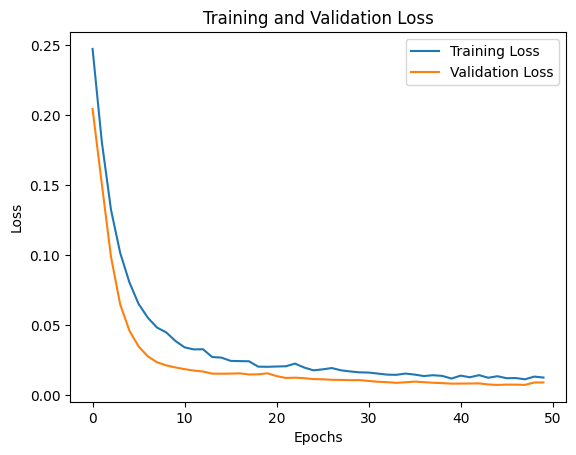

In [5]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss') 
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [6]:
autoencoder.save("autoencoder.h5")

In [ ]:
!pip install --upgrade tensorflow keras


In [8]:
import os
import cv2
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256))
    img = img / 255.0
    return img

def load_images_from_directory(directory):
    image_list = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(directory, filename)
            img = preprocess_image(img_path)
            image_list.append(img)
    return np.array(image_list, dtype=np.float32)

def display_images(original, reconstructed, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i])
        plt.title("Original")
        plt.axis("off")
        
        # Display reconstructed images
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i])
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

def main():
    # Load the trained autoencoder model
    autoencoder = load_model("autoencoder.h5")
    
    # Directory containing test images
    test_image_dir = "images"
    
    # Load and preprocess test images
    X_test = load_images_from_directory(test_image_dir)
    
    # Make predictions
    reconstructed_images = autoencoder.predict(X_test)
    
    # Display original and reconstructed images
    display_images(X_test, reconstructed_images, n=10)

if __name__ == "__main__":
    main()


ImportError: cannot import name 'ImageDataGenerator' from 'keras.preprocessing.image' (C:\Users\amish\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\api\preprocessing\image\__init__.py)